Сначала нужно посмотреть, какие датасеты мы можем считать (тут есть разные форматы такие как csv, xlsx, ods), а далее посмотрим что у них внутри

In [1]:
import numpy as np
import pandas as pd
import os 

with open("info/tables_info.txt", "w") as fout:
    for table in os.listdir("./Проект"):
        df = None

        if table.endswith("csv"):
            df = pd.read_csv("Проект/" + table, on_bad_lines='skip', low_memory=False)
        elif table.endswith("xlsx"):
            try:
                df = pd.read_excel("Проект/" + table)
            except:
                print("[Excel not parsed]", table)
        elif table.endswith("ods"):
            try:
                df = pd.read_excel("Проект/" + table, engine='odf')
            except:
                print("[Ods not parsed]", table)
        else:
            print("[Unknown]", table) 

        if df is not None:
            fout.write(table + "\n")

Смогли считать все датасеты, теперь нужно посмотреть, что у них внутри

In [2]:
with open("info/columns_info.txt", "w") as fout:
    for table in os.listdir("./Проект"):
        df = None

        if table.endswith("csv"):
            df = pd.read_csv("Проект/" + table, on_bad_lines='skip', low_memory=False)
        elif table.endswith("xlsx"):
            try:
                df = pd.read_excel("Проект/" + table)
            except:
                print("[Excel not parsed]", table)
        elif table.endswith("ods"):
            try:
                df = pd.read_excel("Проект/" + table, engine='odf')
            except:
                print("[Ods not parsed]", table)
        else:
            print("[Unknown]", table) 

        if df is not None:
            fout.write(table + "\n")
            fout.write(f"Shape: {df.shape}" + "\n")
            cols = [col for col in list(df.columns.values) if "Unnamed" not in col.strip()]
            fout.write(f"Columns: \n{"\n".join(cols)}\n\n")
            fout.write("#" * 100 + "\n\n")


Смотрим в файл columns_info.txt, чтобы понять, какие колонки у нас есть, в основном это информация о студенте (курс, группа, факультет, фио, почта) и его результаты (оценки, тесты, сдал/не сдал, баллы, проценты, перцентили и т.д.)

Теперь нужно сджойнить все данные в одну таблицу и работать уже с ней.

In [3]:
dfs = []
dfs_names = []

for table in os.listdir("./Проект"):
        df = None

        if table.endswith("csv"):
            df = pd.read_csv("Проект/" + table, on_bad_lines='skip', low_memory=False)
        elif table.endswith("xlsx"):
            try:
                df = pd.read_excel("Проект/" + table)
            except:
                print("[Excel not parsed]", table)
        elif table.endswith("ods"):
            try:
                df = pd.read_excel("Проект/" + table, engine='odf')
            except:
                print("[Ods not parsed]", table)
        else:
            print("[Unknown]", table) 

        if df is not None:
            dfs.append(df)
            dfs_names.append(table)

print(len(dfs))

23


Теперь все таблицы лежат в списке dfs, их имена в dfs_names

Теперь нам нужен уникальный id для человека, брать ФИО мы не можем, так как будут коллизии, поэтому будем использовать почту (при коллизии к почте добавляется номер человека), при этом такой выбор согласуется с логикой, ведь было бы странно если бы вуз раздавал одинаковые почты в своем домене. Теперь нужно найти все почты и далее приджойнить все колонки из таблиц.

В Таблице НЭ_с_2021я таблица для дэшборда.xlsx есть дубликаты почт, потому что это результаты за несколько лет обучения, поэтому нужно объединить их под одну почту

In [4]:
dfs[-1].columns.values

array(['ФИО', 'Адрес электронной почты', 'Филиал', 'Факультет', 'ОП',
       'Группа', 'Курс', 'ОЦЕНКА', 'НЭ', 'Год', 'Поток', 'Онлайн-курс',
       'ИУС', 'Демо-версия', 'Сдал/не сдал', 'Сдал-не-сдал',
       'Больше половины онлайн-курса', 'Оценка за онлайн курс', 'Чек'],
      dtype=object)

In [5]:
#CHANGED BLOCK!!!!
# Create base dataframe with sequential counter
df = dfs[-1].copy()
df['seq_num'] = df.groupby('Адрес электронной почты').cumcount() + 1

# Define columns to pivot
pivot_columns = {
    'ОЦЕНКА': 'ОЦЕНКА_',
    'Год': 'Год_',
    'Курс': 'Курс_',
    'Онлайн-курс': 'Онлайн-курс_',
    'ИУС': 'ИУС_',
    'Демо-версия': 'Демо-версия_',
    'Сдал-не-сдал': 'Сдал-не-сдал_'
}

# Create all pivot tables at once
pivot_tables = {
    prefix: df.pivot(
        index='Адрес электронной почты',
        columns='seq_num',
        values=col
    ).add_prefix(prefix)
    for col, prefix in pivot_columns.items()
}

# Get email metadata (first occurrence for each email)
email_metadata = df.groupby('Адрес электронной почты').first()

# Combine all pieces
result_df = pd.concat([email_metadata] + list(pivot_tables.values()), axis=1)

# Clean up the result
columns_to_drop = [
    'Группа', 'Курс', 'ОЦЕНКА', 'Год', 'Онлайн-курс', 'ИУС', 
    'Демо-версия', 'Сдал-не-сдал', 'Сдал/не сдал',
    'Больше половины онлайн-курса', 'Чек', 'Оценка за онлайн курс'
]
result_df = (result_df
    .fillna('')
    .reset_index()
    .drop(columns=columns_to_drop)
)

In [6]:
old_ie = dfs[-1].copy()
dfs[-1] = result_df

In [7]:
email_cols = set(["Адрес электронной почты", "Email address", "Адрес студенческой почты", "Логин"])

for i in range(len(dfs)):
    cols = dfs[i].columns.values
    if len(email_cols.intersection(cols)) == 0:
        print(i, dfs_names[i])
        print(cols)
        print()

Здесь я нашел все колонки, где может быть почта, ведь они могут иметь разные названия в разных таблицах

In [8]:
emails = []

for i in range(len(dfs)):
    for email_col in email_cols:
        if email_col in dfs[i].columns.values:
            emails.extend(dfs[i][email_col].values)
            break

In [9]:
emails = list(set(emails))
print(len(emails))

emails = [x for x in emails if isinstance(x, str)]
print(len(set(emails)), len(emails))

123452
123451 123451


Тут я получил множество всех уникальных почт людей, теперь можно приджойнить все таблицы по почте

In [10]:
df_all = pd.DataFrame(emails, columns=["email"])

for i in range(len(dfs)):
    for email_col in email_cols:
        if email_col in dfs[i].columns.values:
            df_renamed = dfs[i].copy()
            df_renamed.rename(columns={col: f"{col}_{dfs_names[i]}" for col in dfs[i].columns.values}, inplace=True)

            df_all = pd.merge(df_all, df_renamed,
                                left_on='email',
                                right_on=email_col + "_" + dfs_names[i],
                                how='left',
                                suffixes=('_df1', '_df2'))
            if len(df_all['email'].unique().tolist()) != len(df_all['email'].tolist()):
                print("Duplicate emails!!!")
            break


df_all.head()

,email,Unnamed: 0_Выполнение елементов учебника по АД_нач_англ.csv,Адрес электронной почты_Выполнение елементов учебника по АД_нач_англ.csv,Данные о пользователе_Выполнение елементов учебника по АД_нач_англ.csv,User information_Выполнение елементов учебника по АД_нач_англ.csv,Страна_Выполнение елементов учебника по АД_нач_англ.csv,Forum_Выполнение елементов учебника по АД_нач_англ.csv,Unnamed: 6_Выполнение елементов учебника по АД_нач_англ.csv,Specification of the Independent Data Science Test of Elementary Level_Выполнение елементов учебника по АД_нач_англ.csv,Unnamed: 8_Выполнение елементов учебника по АД_нач_англ.csv,...,Демо-версия_3_НЭ_с_2021я таблица для дэшборда.xlsx,Демо-версия_4_НЭ_с_2021я таблица для дэшборда.xlsx,Демо-версия_5_НЭ_с_2021я таблица для дэшборда.xlsx,Демо-версия_6_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_1_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_2_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_3_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_4_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_5_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_6_НЭ_с_2021я таблица для дэшборда.xlsx
0,mrkhabibullina@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,asgorodnicheva@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,s10667300407@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,avshvets@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tovolkova@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_all[df_all['email'].duplicated()]['email'].unique()
# df_all[df_all['email'] == 'psoseneva@edu.hse.ru']

array([], dtype=object)

здесь я удалю все колонки, где нет имени

In [12]:
df_all.drop([col for col in df_all.columns.values if 'Unnamed' in col], axis=1, inplace=True)
print(len(list(df_all.columns.values)))

1102


здесь я выделил все колонки, где есть полезная информация


In [13]:
col_patterns = ['test', 'тест', 'оценка', 'variant', 'вариант', 'practice', 'hypothesis', 'практика'
             'гипотеза', 'задание', 'task', 'самопроверка', 'лекция', 'инструмент', 'видео', 
             'глава', 'quiz', 'норм', 'сумма', 'перцентиль', 'балл', 'место', 'course', ]

used_cols = [col for col in df_all.columns.values if any([pat in col.lower() for pat in col_patterns])]
df_used = df_all[used_cols + ['email']]
df_used.shape

(123451, 766)

Тут я прохожусь по всем значениям большой таблицы и пытаюсь преобзовать их в числа для дальнейшего обучения модели

In [14]:
for x in df_used.drop(columns=['email'], inplace=False).values.flatten().tolist():
    if isinstance(x, float):
        continue
    if isinstance(x, str) and x == '':
        continue
    if isinstance(x, str) and '/' in x:    
        a, b = x.split('/')
        a, b = a.strip(), b.strip()
        try:
            if a.lower() == 'null' or b.lower() == 'null':
                c = 1
            else:
                c = float(a) / float(b)
        except Exception as e:
            print(e, x)
        continue
    if x in ['Выполнено', 'Не выполнено', '-']:
        continue
    try:
        if isinstance(x, str):
            x = x.replace(',', '.')
        x = float(x)
    except Exception as e:
        print(e, x)

In [15]:
import math

def process_value(x):
    if type(x) == float and math.isnan(x):
        return 0

    if isinstance(x, float):
        return x
    if isinstance(x, str) and x == '':
        return 0
    if isinstance(x, str) and '/' in x:
        a, b = x.split('/')
        a, b = a.strip(), b.strip()
        if a.lower() == 'null' or b.lower() == 'null':
            return 1.0
        return float(a) / float(b)
    
    if isinstance(x, str):
        if x.lower() == 'выполнено':
            return 1.0
        elif x.lower() in ['не выполнено', '-']:
            return 0.0
        x = x.replace(',', '.')
    
    return float(x)

processed_df = df_used.drop(columns=['email'], inplace=False).apply(lambda x: x.apply(process_value))
processed_df['email'] = df_used['email']
processed_df.shape

(123451, 766)

Теперь в таблице processed_df все значения преобразованы в числа и можно обучать модель, но для начала нужно разделить данные на тренировочную и тестовую выборки


Из текущего датасета нужно вытащить целевую переменную, остальное берем как признаковое описание.
Таргетом будет оценка за независимый экзамен, поэтому будем использовать лишь множество почт из этой таблицы (НЭ_с_2021я таблика для дэщборда.xlsx)

In [16]:
with open("info/processed_columns_info.txt", "w", encoding='utf-8') as fout:
    fout.write(f"Total number of columns: {len(processed_df.columns)}\n\n")
    fout.write("Columns:\n")
    for i, col in enumerate(processed_df.columns, 1):
        fout.write(f"{i}. {col}\n")

Нашел ее название в общей таблице - "ОЦЕНКА_{год обучения}_НЭ_с_2021я таблица для дэшборда.xlsx", значит нужно завести новую колонку target, которая будет отвечать за последную оценку студента по НЭ, при этом если оценки нет, то мы на нем обучаться не можем, таких студентов пока просто выкинем из выборки.
И не забудем ограничить датасет по почтам, для которых мы знаем таргет.

In [17]:
import pandas as pd

# Get all grade columns
grade_cols = [f'ОЦЕНКА_{i}_НЭ_с_2021я таблица для дэшборда.xlsx' for i in range(1, 7)]

# Create grade_last column by checking each grade column from right to left
processed_df['target'] = processed_df[grade_cols].replace(0, np.nan).ffill(axis=1).iloc[:, -1]
processed_df = processed_df[processed_df['target'].notna()]
print(processed_df.shape)

(28112, 767)


In [18]:
valid_emails = set(pd.read_excel("Проект/НЭ_с_2021я таблица для дэшборда.xlsx")["Адрес электронной почты"].values)
print(len(valid_emails))

filtered_df = processed_df[processed_df['email'].isin(valid_emails)]
filtered_df.shape

28873


(28112, 767)

### Feature Engineeging

Я бы разделил фичи на классы следующим образом:
- оценка за НЭ: средняя оценка за уже пройденные, количество зачетов / незачетов, последняя оценка
- оценки в целом: средняя оценка, дисперсия оценок, мин / макс оценка
- рейтинги: место на оп / курсе / кампусе, перцентили, рейтинги
- пройденный материал: лекции / семинары / видео / тесты / квизы / главы курсов / практики / демо-варианты
- егэ: результаты егэ по математике / информатике / русскому

Для всех классов выше можно придумать как их посчитать, а для класса "пройденный материал" сделаем svd разложение, чтобы получить по "знаниям" (пройденным тестам) вектор студента и уже его значения можно будет использовать. 

In [207]:
final_df = pd.DataFrame()
final_df["email"] = filtered_df["email"]
final_df["target"] = filtered_df["target"]

In [208]:
# Оценки за НЭ

def get_second_last_non_null(row):
    non_null_values = row.dropna().values
    if len(non_null_values) >= 2:
        return non_null_values[-2]
    return 0.0

def get_count_passed(row):
    non_null_values = row.dropna().values
    return len([x for x in non_null_values if x >= 4.0])

def get_count_failed(row):
    non_null_values = row.dropna().values
    return len([x for x in non_null_values if x < 4.0])


final_df['count_passed'] = filtered_df[grade_cols].replace(0.0, np.nan).apply(get_count_passed, axis=1)
final_df['count_failed'] = filtered_df[grade_cols].replace(0.0, np.nan).apply(get_count_failed, axis=1)

final_df['last_it_grade'] = filtered_df[grade_cols].replace(0.0, np.nan).apply(get_second_last_non_null, axis=1)

grades_sum = filtered_df[grade_cols].sum(axis=1)
grades_count = filtered_df[grade_cols].replace(0.0, np.nan).apply(lambda row: row.count(), axis=1)
final_df['mean_ie_grade'] = grades_sum / grades_count


final_df.head()

,email,target,count_passed,count_failed,last_it_grade,mean_ie_grade
7,nababarykin@edu.hse.ru,5.0,2,0,8.0,6.500000
16,grzintsov@edu.hse.ru,6.0,3,0,9.0,7.666667
18,msmozhaev@edu.hse.ru,8.0,1,0,0.0,8.000000
22,rasamodinov@edu.hse.ru,8.0,3,0,10.0,8.333333
24,nkmardzhanian@edu.hse.ru,8.0,1,0,0.0,8.000000


In [209]:
# Оценки в целом 
grades_overall_columns = [
    "Средняя оценка_Рейтинг 21-22 года.csv",
    "Средняя оценка_Рейтинг 22-23 года.csv",
    "Средняя оценка_Рейтинг 23-24 года.csv",
]

def get_grades_mean(row):
    non_zero_values = row[row != 0]
    return non_zero_values.mean() if not non_zero_values.empty else 0.0

def last_non_zero_value(row):
    non_zero_values = row[row != 0]
    return non_zero_values.iloc[-1] if not non_zero_values.empty else 0.0

def variance_non_zero(row):
    non_zero_values = row[row != 0]
    var = non_zero_values.var() if not non_zero_values.empty else 0.0
    return var if var != np.nan else 0.0

def get_grades_min(row):
    non_zero_values = row[row != 0]
    return non_zero_values.min() if not non_zero_values.empty else 0.0


final_df['grader_overall_mean'] = filtered_df[grades_overall_columns].apply(last_non_zero_value, axis=1)
final_df['last_non_zero'] = filtered_df[grades_overall_columns].apply(last_non_zero_value, axis=1)
final_df['variance_non_zero'] = filtered_df[grades_overall_columns].apply(variance_non_zero, axis=1).fillna(0.0)
final_df['min_non_zero'] = filtered_df[grades_overall_columns].apply(get_grades_min, axis=1)

final_df.head()

,email,target,count_passed,count_failed,last_it_grade,mean_ie_grade,grader_overall_mean,last_non_zero,variance_non_zero,min_non_zero
7,nababarykin@edu.hse.ru,5.0,2,0,8.0,6.500000,7.08,7.08,0.646633,5.50
16,grzintsov@edu.hse.ru,6.0,3,0,9.0,7.666667,9.00,9.00,0.520833,7.75
18,msmozhaev@edu.hse.ru,8.0,1,0,0.0,8.000000,0.00,0.00,0.000000,0.00
22,rasamodinov@edu.hse.ru,8.0,3,0,10.0,8.333333,0.00,0.00,0.000000,0.00
24,nkmardzhanian@edu.hse.ru,8.0,1,0,0.0,8.000000,0.00,0.00,0.000000,0.00


In [212]:
# Рейтинги
ratings_overall_columns = [
    "КР сумма_Рейтинг 22-23 года.csv",
    "КР сумма норм_Рейтинг 22-23 года.csv",
    "КРгр сумма норм_Рейтинг 22-23 года.csv",
    "Норм коэф ГР_Рейтинг 22-23 года.csv",
    "Норм коэф_Рейтинг 22-23 года.csv",
    "Сумма кредитов_Рейтинг 22-23 года.csv",
    "Перцентиль_Рейтинг 22-23 года.csv",
    "Минимальный балл_Рейтинг 22-23 года.csv",
    "Место на ОП_Рейтинг 22-23 года.csv",
    "Место в кампусе_Рейтинг 22-23 года.csv",
    "Место на Курсе-ОП_Рейтинг 22-23 года.csv",
    "Место на ОПгр_Рейтинг 22-23 года.csv",
    "КР сумма_Рейтинг 21-22 года.csv",
    "КР сумма норм_Рейтинг 21-22 года.csv",
    "КРгр сумма норм_Рейтинг 21-22 года.csv",
    "Норм коэф ГР_Рейтинг 21-22 года.csv",
    "Норм коэф_Рейтинг 21-22 года.csv",
    "Сумма кредитов_Рейтинг 21-22 года.csv",
    "Перцентиль_Рейтинг 21-22 года.csv",
    "Минимальный балл_Рейтинг 21-22 года.csv",
    "Место на ОП_Рейтинг 21-22 года.csv",
    "Место в кампусе_Рейтинг 21-22 года.csv",
    "Место на Курсе-ОП_Рейтинг 21-22 года.csv",
    "Место на ОПгр_Рейтинг 21-22 года.csv",
    "Место на ОП_Рейтинг 23-24 года.csv",
    "Место в кампусе_Рейтинг 23-24 года.csv",
    "Место на Курсе-ОП_Рейтинг 23-24 года.csv",
    "Место на ОПгр_Рейтинг 23-24 года.csv",
    "Перцентиль_Рейтинг 23-24 года.csv",
    "КР сумма_Рейтинг 23-24 года.csv",
    "КР сумма норм_Рейтинг 23-24 года.csv",
    "КРгр сумма норм_Рейтинг 23-24 года.csv",
    "Норм коэф ГР_Рейтинг 23-24 года.csv",
    "Норм коэф_Рейтинг 23-24 года.csv",
    "Сумма кредитов_Рейтинг 23-24 года.csv",
    "Минимальный балл_Рейтинг 23-24 года.csv",
]

final_df[ratings_overall_columns] = filtered_df[ratings_overall_columns]

Посмотрим на статистику по рейтингам

In [213]:
table = []
for col in ratings_overall_columns:
    mi = final_df[col].min()
    ma = final_df[col].max()
    cnt = final_df[col].apply(lambda x: x != np.nan).sum()
    su = final_df[col].sum()
    cnt_zero = final_df[col].apply(lambda x: x == 0).sum()
    cnt_null = final_df[col].apply(lambda x: x == np.nan).sum()
    table.append([col, mi, ma, cnt, su, su / cnt, final_df[col].var(), cnt_zero , cnt_null])

df = pd.DataFrame(table, columns=["name", "min", "max", "cnt", "sum", "avg", "std", "cnt_zero", "cnt_null"])
df.head(36)

,name,min,max,cnt,sum,avg,std,cnt_zero,cnt_null
0,КР сумма_Рейтинг 22-23 года.csv,0.0,605.000000,28112,1.919535e+06,68.281695,13827.984570,20557,0
1,КР сумма норм_Рейтинг 22-23 года.csv,0.0,882.970000,28112,2.805229e+06,99.787614,30905.543784,20557,0
2,КРгр сумма норм_Рейтинг 22-23 года.csv,0.0,13.250000,28112,1.108753e+04,0.394406,0.453488,20547,0
3,Норм коэф ГР_Рейтинг 22-23 года.csv,0.0,746.850000,28112,2.573131e+06,91.531403,28240.395741,21077,0
4,Норм коэф_Рейтинг 22-23 года.csv,0.0,13.250000,28112,1.013237e+04,0.360429,0.412321,21069,0
5,Сумма кредитов_Рейтинг 22-23 года.csv,0.0,110.000000,28112,2.848260e+05,10.131830,284.998095,20547,0
6,Перцентиль_Рейтинг 22-23 года.csv,0.0,100.000000,28112,3.703481e+05,13.174023,694.784495,20633,0
7,Минимальный балл_Рейтинг 22-23 года.csv,0.0,10.000000,28112,3.091800e+04,1.099815,4.871471,21597,0
8,Место на ОП_Рейтинг 22-23 года.csv,0.0,1.000000,28112,3.769770e+03,0.134098,0.071094,20547,0
9,Место в кампусе_Рейтинг 22-23 года.csv,0.0,0.998062,28112,3.763131e+03,0.133862,0.070886,20547,0


Как видим нет каких-то сильных выбросов, однако есть большое количество нулей в каждом столбце, что довольно ожидаемо

In [214]:
# ЕГЭ
final_df["Балл_ЕГЭ_математика"] = filtered_df["Балл ЕГЭ_Выгрузка по ЕГЭ с 2020 года.xlsx"]
final_df["Балл_ЕГЭ_математика"].value_counts()

Балл_ЕГЭ_математика
0.0      13753
5.0       1454
78.0       989
76.0       979
80.0       922
82.0       895
74.0       865
84.0       813
72.0       781
70.0       737
86.0       707
4.0        618
88.0       590
68.0       579
100.0      534
90.0       488
92.0       390
94.0       316
66.0       310
96.0       250
64.0       231
62.0       187
98.0       158
58.0        90
99.0        75
3.0         58
52.0        57
50.0        51
56.0        47
40.0        41
46.0        39
45.0        30
27.0        19
34.0        18
39.0        16
33.0         9
97.0         2
81.0         2
75.0         2
69.0         2
93.0         1
65.0         1
85.0         1
89.0         1
71.0         1
55.0         1
87.0         1
61.0         1
Name: count, dtype: int64

Есть баллы ЕГЭ равные 3, 4, 5, должна быть ошибка в данных, так как студенты должны были сдать егэ оп математике хотя бы на порог, поэтому сами почистим такое 

In [215]:
final_df["Балл_ЕГЭ_математика"] = final_df["Балл_ЕГЭ_математика"].apply(lambda x: x if x > 5 else 0.0)

In [216]:
# пройденный материал
 
not_tests_columns = grade_cols + grades_overall_columns + ratings_overall_columns + ["Балл ЕГЭ_Выгрузка по ЕГЭ с 2020 года.xlsx", "target", "email"]

only_tests_columns = filtered_df.drop(not_tests_columns, axis=1)

table = []
for col in only_tests_columns:
    mi = filtered_df[col].min()
    ma = filtered_df[col].max()
    cnt = filtered_df[col].apply(lambda x: x != np.nan).sum()
    su = filtered_df[col].sum()
    cnt_zero = filtered_df[col].apply(lambda x: x == 0).sum()
    cnt_null = filtered_df[col].apply(lambda x: x == np.nan).sum()
    table.append([col, mi, ma, cnt, su, su / cnt, filtered_df[col].var(), cnt_zero, cnt_zero / len(filtered_df), cnt_null])

df = pd.DataFrame(table, columns=["name", "min", "max", "cnt", "sum", "avg", "std", "cnt_zero", "cnt_zero_perc", "cnt_null"])

Выделим только те материалы, которые имеют хотя бы 1% пройденности среди стедентов, тесты с пройденностью менее процента будут добавлять лишь шум в данные

In [217]:
# df[df["cnt_zero_perc"] < 0.99].size = 403
df[df["cnt_zero_perc"] < 0.99].head(10)

,name,min,max,cnt,sum,avg,std,cnt_zero,cnt_zero_perc,cnt_null
5,Тест:ЗАДАНИЕ А-01 (Значение)_Курс подготовки к...,0.0,10.0,28112,19233.0,0.684156,6.314276,26155,0.930386,0
6,Тест:ЗАДАНИЕ А-02 (Значение)_Курс подготовки к...,0.0,10.0,28112,17165.0,0.610593,5.614321,26333,0.936717,0
7,Тест:ЗАДАНИЕ А-03 (Значение)_Курс подготовки к...,0.0,10.0,28112,16093.0,0.572460,5.329814,26468,0.941520,0
8,Тест:ЗАДАНИЕ А-04 (Значение)_Курс подготовки к...,0.0,10.0,28112,15192.0,0.540410,4.998260,26537,0.943974,0
9,Тест:ЗАДАНИЕ А-05 (Значение)_Курс подготовки к...,0.0,10.0,28112,14213.0,0.505585,4.648469,26614,0.946713,0
10,Тест:ЗАДАНИЕ А-06 (Значение)_Курс подготовки к...,0.0,10.0,28112,13236.0,0.470831,4.322368,26698,0.949701,0
11,Тест:ЗАДАНИЕ В-01 (Значение)_Курс подготовки к...,0.0,10.0,28112,12847.0,0.456993,4.222902,26754,0.951693,0
12,Тест:ЗАДАНИЕ В-02 (Значение)_Курс подготовки к...,0.0,10.0,28112,10946.0,0.389371,3.556115,26910,0.957242,0
13,Тест:ЗАДАНИЕ В-03 (Значение)_Курс подготовки к...,0.0,10.0,28112,8231.0,0.292793,2.670948,27181,0.966882,0
14,Тест:ЗАДАНИЕ В-04 (Значение)_Курс подготовки к...,0.0,10.0,28112,9786.0,0.348108,3.297336,27099,0.963966,0


В столбцах имеем разные распределения значений, поэтому сделаем нормализацию

In [231]:
from sklearn.preprocessing import StandardScaler

prep_cols = df[df["cnt_zero_perc"] < 0.99]["name"].values
nums_df = filtered_df[prep_cols]

scaler = StandardScaler()
nums_df[nums_df.columns] = scaler.fit_transform(nums_df)
nums_df.head()

/var/folders/c5/sl3gtg7112l8d_m0wj8p6dnm0000gn/T/ipykernel_51863/1431924246.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nums_df[nums_df.columns] = scaler.fit_transform(nums_df)


,Тест:ЗАДАНИЕ А-01 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-02 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-03 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-04 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-05 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-06 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-01 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-02 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-03 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-04 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,...,Самопроверка.4_Выполнение елементов учебника по АД_база.csv,Тест.2_Выполнение елементов учебника по АД_база.csv,Глава 8. z-оценка и z-распределение_Выполнение елементов учебника по АД_база.csv,Видео | Теория: z-оценка_Выполнение елементов учебника по АД_база.csv,Глава 9. Выбросы_Выполнение елементов учебника по АД_база.csv,Глава 10. Корреляция_Выполнение елементов учебника по АД_база.csv,Видео | Теория: корреляция_Выполнение елементов учебника по АД_база.csv,Глава 11. Использование и интерпретация корреляции_Выполнение елементов учебника по АД_база.csv,Видео | Теория: регрессия_Выполнение елементов учебника по АД_база.csv,Глава 12. Линия тренда и предсказание значений признака_Выполнение елементов учебника по АД_база.csv
7,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,-0.11861,-0.106964,-0.118146,-0.123896,-0.118764,-0.111303,-0.110811,-0.109487,-0.108987,-0.103859
16,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,-0.11861,-0.106964,-0.118146,-0.123896,-0.118764,-0.111303,-0.110811,-0.109487,-0.108987,-0.103859
18,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,-0.11861,-0.106964,-0.118146,-0.123896,-0.118764,-0.111303,-0.110811,-0.109487,-0.108987,-0.103859
22,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,-0.11861,-0.106964,8.464090,8.071300,8.420077,-0.111303,-0.110811,-0.109487,-0.108987,-0.103859
24,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,-0.11861,-0.106964,-0.118146,-0.123896,-0.118764,-0.111303,-0.110811,-0.109487,-0.108987,-0.103859


Подберем количество компонент в SVD по доли объясненной дисперсии

In [232]:
from sklearn.decomposition import TruncatedSVD

comps = 18

# Выполняем SVD-разложение
svd = TruncatedSVD(n_components=comps)  # Выбираем comps компоненты для примера
svd_coordinates = svd.fit_transform(nums_df)  # Получаем координаты SVD
svd_columns = [f'SVD_{i+1}' for i in range(svd_coordinates.shape[1])]

# Создаем DataFrame из координат SVD с теми же индексами, что и исходный DataFrame
svd_df = pd.DataFrame(svd_coordinates, columns=svd_columns, index=nums_df.index)

# Объединяем исходный DataFrame с координатами SVD
nums_svd_df = pd.concat([nums_df, svd_df], axis=1)

# Результат
nums_svd_df.head()

,Тест:ЗАДАНИЕ А-01 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-02 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-03 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-04 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-05 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-06 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-01 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-02 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-03 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-04 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,...,SVD_9,SVD_10,SVD_11,SVD_12,SVD_13,SVD_14,SVD_15,SVD_16,SVD_17,SVD_18
7,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,-0.048279,0.055386,0.405036,-0.638087,0.057656,0.236869,-0.271715,-0.365441,0.009350,-0.115080
16,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,0.778319,-0.412645,0.181743,-0.924038,-0.686412,-0.009040,-0.268347,-0.742641,-0.116340,0.111022
18,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,0.209179,-0.411683,-0.013726,-0.388781,-0.672874,-0.156117,0.144997,-0.103520,-0.228730,-0.027188
22,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,-3.926823,11.744377,4.179860,-1.914543,-1.101490,-0.124377,-2.097550,1.827677,11.063911,1.422411
24,-0.272271,-0.257698,-0.247969,-0.241725,-0.234502,-0.226471,-0.222388,-0.206483,-0.179158,-0.191708,...,2.628710,0.365844,-0.036845,0.162244,1.408544,-3.032841,-1.022781,0.455640,-0.500698,0.115492


In [233]:
# Доля объясненной дисперсии для каждой компоненты
explained_variance_ratio = svd.explained_variance_ratio_

# Суммарная доля дисперсии, объясненная первыми comps компонентами
total_explained_variance = explained_variance_ratio.sum()

print(f"Доля дисперсии, объясненная каждой из первых {comps} компонент:\n", explained_variance_ratio)
print(f"Суммарная доля дисперсии, объясненная первыми {comps} компонентами:", total_explained_variance)

Доля дисперсии, объясненная каждой из первых 18 компонент:
 [0.15481488 0.13477461 0.08214637 0.0461989  0.04392471 0.03487571
 0.03130914 0.02324308 0.02181121 0.01793894 0.01769705 0.01616956
 0.01526601 0.01264307 0.01182698 0.01172466 0.01088186 0.00979124]
Суммарная доля дисперсии, объясненная первыми 18 компонентами: 0.6970379966506278


In [234]:
final_df[svd_columns] = nums_svd_df[svd_columns]
final_df.head()

,email,target,count_passed,count_failed,last_it_grade,mean_ie_grade,grader_overall_mean,last_non_zero,variance_non_zero,min_non_zero,...,SVD_9,SVD_10,SVD_11,SVD_12,SVD_13,SVD_14,SVD_15,SVD_16,SVD_17,SVD_18
7,nababarykin@edu.hse.ru,5.0,2,0,8.0,6.500000,7.08,7.08,0.646633,5.50,...,-0.048279,0.055386,0.405036,-0.638087,0.057656,0.236869,-0.271715,-0.365441,0.009350,-0.115080
16,grzintsov@edu.hse.ru,6.0,3,0,9.0,7.666667,9.00,9.00,0.520833,7.75,...,0.778319,-0.412645,0.181743,-0.924038,-0.686412,-0.009040,-0.268347,-0.742641,-0.116340,0.111022
18,msmozhaev@edu.hse.ru,8.0,1,0,0.0,8.000000,0.00,0.00,0.000000,0.00,...,0.209179,-0.411683,-0.013726,-0.388781,-0.672874,-0.156117,0.144997,-0.103520,-0.228730,-0.027188
22,rasamodinov@edu.hse.ru,8.0,3,0,10.0,8.333333,0.00,0.00,0.000000,0.00,...,-3.926823,11.744377,4.179860,-1.914543,-1.101490,-0.124377,-2.097550,1.827677,11.063911,1.422411
24,nkmardzhanian@edu.hse.ru,8.0,1,0,0.0,8.000000,0.00,0.00,0.000000,0.00,...,2.628710,0.365844,-0.036845,0.162244,1.408544,-3.032841,-1.022781,0.455640,-0.500698,0.115492


Для начала предположим, что время для нас не особо влияет (год сдачи теста / экзамена), важно лишь сдал ли его студент или нет, то есть учитывать будем лишь "знания человека". При таком принципе можно поделить датасет случайно в пропорции 70/30 и замерить качество в предсказании целевой переменной (итоговой экзамен), тем более во время инференса мы всегда будем знать, что все тесты пройдены в прошлом.

Для начала давайте обучим бейзлайн модель, с которой будем сравнивать результаты. Давайте вспомним, что в данной задаче нам нужно максимизировать recall, то есть добиться максимального покрытия множество людей, которые не сдадут экзамен, ведь наше дело предупредить студента или его учителя, что есть проблемы с изучением курса, а если мы посоветуем дополнительные занятия человека, который и без них бы сдал экзамен, то ничего плохого не произойдет.

In [241]:
X = final_df.drop(columns=['email', 'target'])
y = final_df['target']

print(X.dtypes.unique(), y.dtypes)
print(X.shape, y.shape)

[dtype('int64') dtype('float64')] float64
(28112, 63) (28112,)


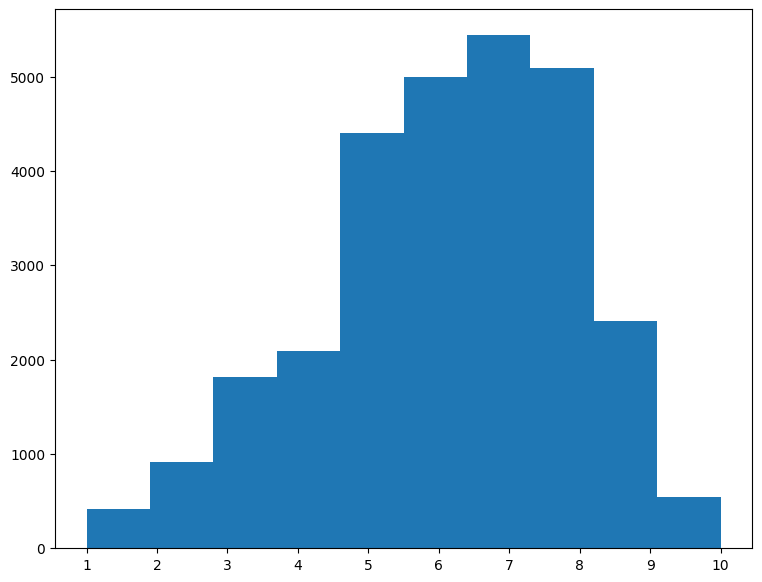

In [242]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 7))
plt.hist(y, bins=10)
plt.xticks(np.arange(1, 11, 1))
plt.show()

Распределение целевой переменной ожидаемое, имеет среднее 6-7, больше смещено в сторону 5+

На данный момент получили обучающую выборку, теперь нужно разделить ее на тренировочную и тестовую в пропорции 70/30 и замерить качество на разных моделях.

In [243]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19678, 63) (19678,)
(8434, 63) (8434,)


Теперь займемся обучением моделей и замером качества, измерять качество будем по RMSE, чтобы знать среднее отклонение предсказаний от истинных значений. 

Начнем с линейной регрессии, только не забудем нормализовать признаки.

In [244]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calculate RMSE for both training and test sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Training RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

# Optional: Print feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=lambda x: x, ascending=False).head(10)
print('\nFeature Coefficients:')
print(feature_importance)

Training RMSE: 0.8687
Test RMSE: 0.8688

Feature Coefficients:
                                     Feature  Coefficient
29    Место в кампусе_Рейтинг 21-22 года.csv     5.386681
33    Место в кампусе_Рейтинг 23-24 года.csv     2.765772
17    Место в кампусе_Рейтинг 22-23 года.csv     2.111148
3                              mean_ie_grade     1.879747
32        Место на ОП_Рейтинг 23-24 года.csv     0.780605
0                               count_passed     0.668812
7                               min_non_zero     0.614232
38      КР сумма норм_Рейтинг 23-24 года.csv     0.594508
16        Место на ОП_Рейтинг 22-23 года.csv     0.472077
30  Место на Курсе-ОП_Рейтинг 21-22 года.csv     0.393861


Теперь сразу попробуем обучить сильную модель - градиентный бустинг, посмотрим на сколько улучшится качество

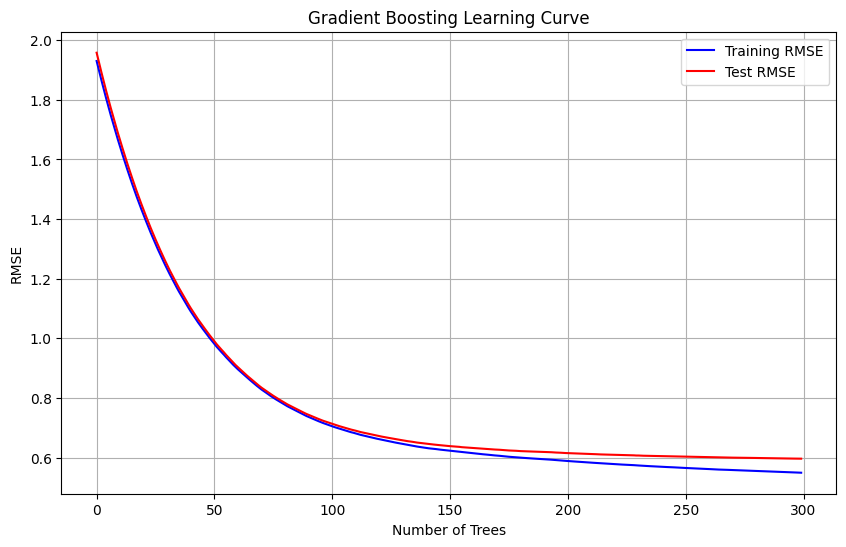


Feature Importances:
                                    Feature  Importance
3                             mean_ie_grade    0.778469
2                             last_it_grade    0.105020
0                              count_passed    0.072707
1                              count_failed    0.016788
27  Минимальный балл_Рейтинг 21-22 года.csv    0.002149
43  Минимальный балл_Рейтинг 23-24 года.csv    0.001480
60                                   SVD_16    0.001201
46                                    SVD_2    0.001038
13    Сумма кредитов_Рейтинг 22-23 года.csv    0.000937
10   КРгр сумма норм_Рейтинг 22-23 года.csv    0.000855

Final Training RMSE: 0.5489
Final Test RMSE: 0.5961


In [248]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize model
gb_model = GradientBoostingRegressor(
    n_estimators=300,        # number of trees
    learning_rate=0.02,       # shrinkage rate
    max_depth=5,            # depth of each tree
    subsample=0.8,          # fraction of samples for each tree
    random_state=42,
    # validation_fraction=0.1  # fraction of training data to use for early stopping
)

# Train model and store losses
gb_model.fit(X_train_scaled, y_train)

# Get staged predictions and calculate RMSE for each stage
train_losses = []
test_losses = []

for y_train_pred in gb_model.staged_predict(X_train_scaled):
    train_losses.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    
for y_test_pred in gb_model.staged_predict(X_test_scaled):
    test_losses.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training RMSE', color='blue')
plt.plot(test_losses, label='Test RMSE', color='red')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Print feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("\nFeature Importances:")
print(feature_importance)

# Make final predictions
y_pred_train = gb_model.predict(X_train_scaled)
y_pred_test = gb_model.predict(X_test_scaled)

print(f"\nFinal Training RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

Очень неплохой результат для регрессии, это значит, что мы почти всегда уверены что студент сдаст либо на x либо на x +- 1

Еще один подход, который можно использовать, это использовать классификацию, то есть предсказывать не оценку, а факт сдачи экзамена. Для этого нужно будет перевести целевую переменную в бинарную, сделаем для этого `binary_target = (target < 4)`, то есть не сдавшие экзамен будут считаться положительными примерами, а не сдавшие - отрицательными.

In [251]:
y_train_binary = (y_train < 4)
y_test_binary = (y_test < 4)

Training metrics:
Precision: 0.9160
Recall: 0.9030
AUC: 0.9948

Test metrics:
Precision: 0.9304
Recall: 0.9168
AUC: 0.9949


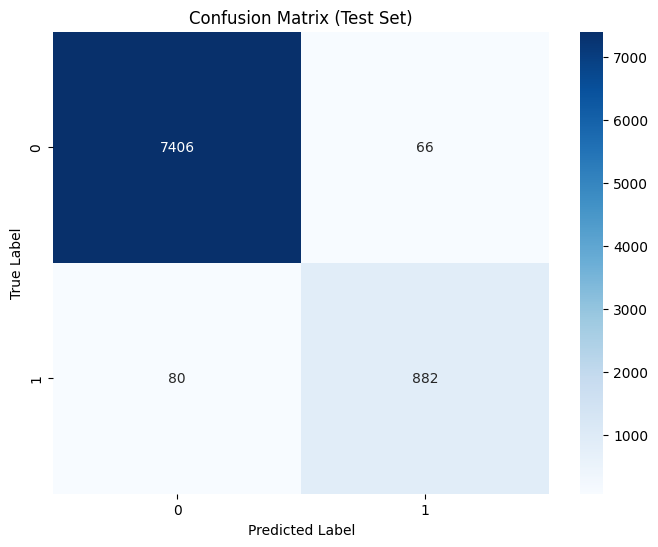


Top 10 Most Important Features:
                                    Feature  Coefficient
2                             last_it_grade     4.637446
0                              count_passed     4.044467
3                             mean_ie_grade     2.401822
1                              count_failed     1.214806
43  Минимальный балл_Рейтинг 23-24 года.csv     0.840067
39   КРгр сумма норм_Рейтинг 23-24 года.csv     0.768052
7                              min_non_zero     0.583245
13    Сумма кредитов_Рейтинг 22-23 года.csv     0.571303
42    Сумма кредитов_Рейтинг 23-24 года.csv     0.541118
53                                    SVD_9     0.521216


In [252]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train logistic regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train_binary)

# Make predictions
y_pred_train_binary = lr_model.predict(X_train_scaled)
y_pred_test_binary = lr_model.predict(X_test_scaled)

# Get probability predictions for AUC
y_pred_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("Training metrics:")
print(f"Precision: {precision_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"Recall: {recall_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"AUC: {roc_auc_score(y_train_binary, y_pred_train_proba):.4f}")

print("\nTest metrics:")
print(f"Precision: {precision_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"Recall: {recall_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"AUC: {roc_auc_score(y_test_binary, y_pred_test_proba):.4f}")

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_binary, y_pred_test_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': abs(lr_model.coef_[0])
}).sort_values('Coefficient', ascending=False).head(10)

print("\nTop 10 Most Important Features:")
print(feature_importance)

Последняя модель выглядит очень неплохо, получил метрики 
- Precision: 0.9304
- Recall: 0.9168
- AUC: 0.9949

А в FP и в FN имеем очень маленькое количество элементов